# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import print_metrics, train_model, count_parameters
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# use data augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
# load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# create data loaders
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Number of trainable parameters: 20490
Epoch: 1/10 	 Train loss: 1.397 	 Train accuracy: 0.628 	 val loss: 1.047 	 val accuracy: 0.688
Epoch: 2/10 	 Train loss: 0.947 	 Train accuracy: 0.710 	 val loss: 0.873 	 val accuracy: 0.724
Epoch: 3/10 	 Train loss: 0.842 	 Train accuracy: 0.732 	 val loss: 0.816 	 val accuracy: 0.736
Epoch: 4/10 	 Train loss: 0.786 	 Train accuracy: 0.746 	 val loss: 0.773 	 val accuracy: 0.749
Epoch: 5/10 	 Train loss: 0.752 	 Train accuracy: 0.752 	 val loss: 0.738 	 val accuracy: 0.760
Epoch: 6/10 	 Train loss: 0.726 	 Train accuracy: 0.761 	 val loss: 0.723 	 val accuracy: 0.761
Epoch: 7/10 	 Train loss: 0.705 	 Train accuracy: 0.767 	 val loss: 0.680 	 val accuracy: 0.773
Epoch: 8/10 	 Train loss: 0.690 	 Train accuracy: 0.770 	 val loss: 0.703 	 val accuracy: 0.768
Epoch: 9/10 	 Train loss: 0.677 	 Train accuracy: 0.776 	 val loss: 0.671 	 val accuracy: 0.775
Epoch: 10/10 	 Train loss: 0.669 	 Train accuracy: 0.776 	 val loss: 0.664 	 val accuracy: 0.785


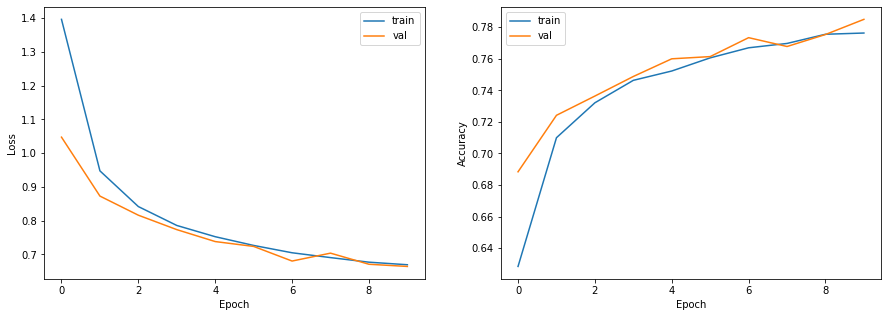

In [3]:
# load ResNet50 model using timm
model = timm.create_model('resnet50', pretrained=True)
# change the last layer to 10 classes
model.fc = nn.Linear(2048, 10)
# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# move model to GPU
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Number of trainable parameters: {}".format(count_parameters(model)))
# use train_model function to train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    airplane     0.7917    0.8060    0.7988      1000
  automobile     0.8433    0.9150    0.8777      1000
        bird     0.7288    0.7580    0.7431      1000
         cat     0.6462    0.7250    0.6833      1000
        deer     0.8382    0.6890    0.7563      1000
         dog     0.8007    0.7110    0.7532      1000
        frog     0.8637    0.8430    0.8532      1000
       horse     0.8305    0.7840    0.8066      1000
        ship     0.8298    0.8920    0.8598      1000
       truck     0.8495    0.8750    0.8621      1000

    accuracy                         0.7998     10000
   macro avg     0.8022    0.7998    0.7994     10000
weighted avg     0.8022    0.7998    0.7994     10000



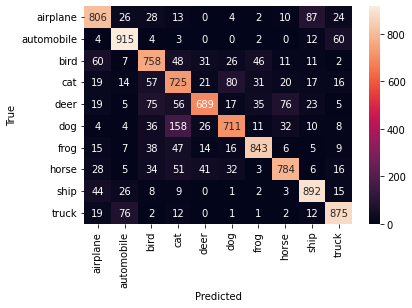

In [4]:
 # test the model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)

In [5]:
# save the model
torch.save(model.state_dict(), 'linear-tuned_resnet50.pth')

### Linear-tuned ResNet50 on CIFAR-10 achieves an acceptable accuracy of 0.80. We will use the knowledge gained from this model to distill the knowledge into a smaller model.

In [16]:
student_model_init = timm.create_model('resnet18', pretrained=False)
student_model_init.fc = nn.Linear(512, 10)
# save the model
torch.save(student_model_init.state_dict(), 'not_pretrained_resnet18.pth')
# define a function to find the best alpha and T using knowlege distillation and choosing the best hyperparameters based on validation accuracy
def find_best_alpha_T(teacher_model, train_loader, test_loader, criterion, optimizer, epochs=10, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9]):
    best_acc = 0
    best_alpha = 0
    best_T = 0
    student_model_init = timm.create_model('resnet18', pretrained=False)
    student_model_init.fc = nn.Linear(512, 10)
    for T in T_list:
        for alpha in alpha_list:
            print(f'alpha={alpha}, T={T}')
            student_model = timm.create_model('resnet18', pretrained=False)
            student_model.fc = nn.Linear(512, 10)
            student_model.load_state_dict(torch.load('not_pretrained_resnet18.pth'))
            student_model = student_model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
            train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, test_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=T, alpha=alpha)
            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]
                best_alpha = alpha
                best_T = T
    return best_acc, best_alpha, best_T


In [17]:
# find the best alpha and T for the case where student model is ResNet18 and teacher model is linear-tuned ResNet50
best_acc, best_alpha, best_T = find_best_alpha_T(model, train_loader, val_loader, criterion, optimizer, epochs=4, T_list=[1, 5, 10], alpha_list=[0.2, 0.5, 0.8])

alpha=0.2, T=1
Epoch: 1/4 	 Train loss: 1.611 	 Train accuracy: 0.466 	 val loss: 1.894 	 val accuracy: 0.409
Epoch: 2/4 	 Train loss: 1.315 	 Train accuracy: 0.632 	 val loss: 1.375 	 val accuracy: 0.614
Epoch: 3/4 	 Train loss: 1.223 	 Train accuracy: 0.700 	 val loss: 2.004 	 val accuracy: 0.393
Epoch: 4/4 	 Train loss: 1.169 	 Train accuracy: 0.741 	 val loss: 1.280 	 val accuracy: 0.686
alpha=0.5, T=1
Epoch: 1/4 	 Train loss: 1.571 	 Train accuracy: 0.457 	 val loss: 1.833 	 val accuracy: 0.431
Epoch: 2/4 	 Train loss: 1.213 	 Train accuracy: 0.640 	 val loss: 1.300 	 val accuracy: 0.609
Epoch: 3/4 	 Train loss: 1.084 	 Train accuracy: 0.718 	 val loss: 1.123 	 val accuracy: 0.701
Epoch: 4/4 	 Train loss: 1.009 	 Train accuracy: 0.762 	 val loss: 1.213 	 val accuracy: 0.685
alpha=0.8, T=1
Epoch: 1/4 	 Train loss: 1.534 	 Train accuracy: 0.450 	 val loss: 1.447 	 val accuracy: 0.491
Epoch: 2/4 	 Train loss: 1.100 	 Train accuracy: 0.639 	 val loss: 1.164 	 val accuracy: 0.628
Epoch

In [18]:
# best_T, best_alpha = 10, 0.5 # From multiple experiments
print(f"Best T={best_T}, best alpha={best_alpha}")

Best T=5, best alpha=0.8


In [20]:
# train the student model with the best alpha and T for the case where student model is ResNet18 and teacher model is linear-tuned ResNet50
student_model = timm.create_model('resnet18', pretrained=False)
student_model.fc = nn.Linear(512, 10)
student_model.load_state_dict(torch.load('not_pretrained_resnet18.pth'))
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=best_T, alpha=best_alpha)

Epoch: 1/10 	 Train loss: 12.351 	 Train accuracy: 0.455 	 val loss: 13.201 	 val accuracy: 0.306
Epoch: 2/10 	 Train loss: 11.851 	 Train accuracy: 0.642 	 val loss: 11.910 	 val accuracy: 0.622
Epoch: 3/10 	 Train loss: 11.670 	 Train accuracy: 0.719 	 val loss: 11.997 	 val accuracy: 0.608
Epoch: 4/10 	 Train loss: 11.541 	 Train accuracy: 0.771 	 val loss: 11.668 	 val accuracy: 0.716
Epoch: 5/10 	 Train loss: 11.454 	 Train accuracy: 0.806 	 val loss: 11.641 	 val accuracy: 0.746
Epoch: 6/10 	 Train loss: 11.387 	 Train accuracy: 0.834 	 val loss: 11.775 	 val accuracy: 0.710
Epoch: 7/10 	 Train loss: 11.334 	 Train accuracy: 0.858 	 val loss: 11.457 	 val accuracy: 0.818
Epoch: 8/10 	 Train loss: 11.295 	 Train accuracy: 0.874 	 val loss: 11.432 	 val accuracy: 0.816
Epoch: 9/10 	 Train loss: 11.266 	 Train accuracy: 0.890 	 val loss: 11.361 	 val accuracy: 0.843
Epoch: 10/10 	 Train loss: 11.229 	 Train accuracy: 0.907 	 val loss: 11.362 	 val accuracy: 0.847


              precision    recall  f1-score   support

    airplane     0.8674    0.8570    0.8622      1000
  automobile     0.9021    0.9580    0.9292      1000
        bird     0.7484    0.8450    0.7938      1000
         cat     0.7297    0.7530    0.7411      1000
        deer     0.8198    0.8690    0.8437      1000
         dog     0.8960    0.7320    0.8057      1000
        frog     0.9044    0.8990    0.9017      1000
       horse     0.8846    0.9120    0.8981      1000
        ship     0.9656    0.8690    0.9147      1000
       truck     0.9250    0.9130    0.9190      1000

    accuracy                         0.8607     10000
   macro avg     0.8643    0.8607    0.8609     10000
weighted avg     0.8643    0.8607    0.8609     10000



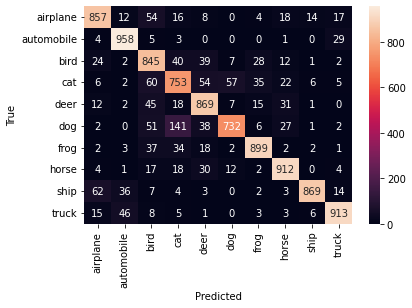

Number of trainable parameters: 11181642


In [21]:
# test the student model on test data
print_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')
# save the model
torch.save(student_model.state_dict(), 'KD_resnet50_to_resnet18.pth')

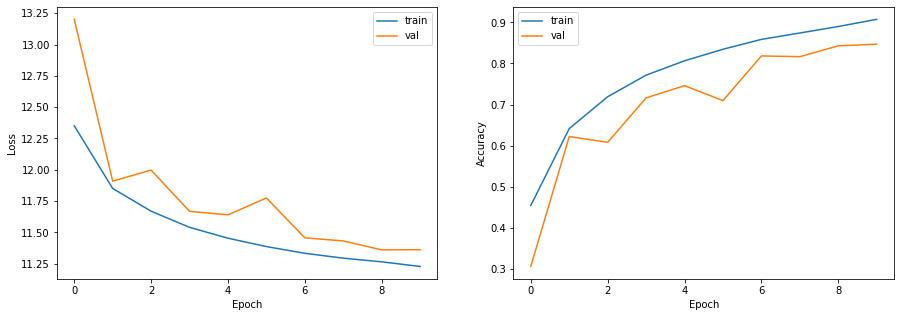

In [22]:
# plot the training and validation loss and accuracy for knowledge distillation of ResNet18 and linear-tuned ResNet50 with best alpha and T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# fine-tune all of resnet18 model without knowledge distillation
model = timm.create_model('resnet18', pretrained=False)
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load('not_pretrained_resnet18.pth'))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/10 	 Train loss: 1.504 	 Train accuracy: 0.446 	 val loss: 1.340 	 val accuracy: 0.503
Epoch: 2/10 	 Train loss: 1.045 	 Train accuracy: 0.625 	 val loss: 1.818 	 val accuracy: 0.465
Epoch: 3/10 	 Train loss: 0.842 	 Train accuracy: 0.701 	 val loss: 0.927 	 val accuracy: 0.667
Epoch: 4/10 	 Train loss: 0.711 	 Train accuracy: 0.749 	 val loss: 0.801 	 val accuracy: 0.720
Epoch: 5/10 	 Train loss: 0.606 	 Train accuracy: 0.789 	 val loss: 0.708 	 val accuracy: 0.759
Epoch: 6/10 	 Train loss: 0.531 	 Train accuracy: 0.816 	 val loss: 1.192 	 val accuracy: 0.649
Epoch: 7/10 	 Train loss: 0.460 	 Train accuracy: 0.840 	 val loss: 0.561 	 val accuracy: 0.810
Epoch: 8/10 	 Train loss: 0.409 	 Train accuracy: 0.858 	 val loss: 0.723 	 val accuracy: 0.766
Epoch: 9/10 	 Train loss: 0.365 	 Train accuracy: 0.872 	 val loss: 0.733 	 val accuracy: 0.762
Epoch: 10/10 	 Train loss: 0.330 	 Train accuracy: 0.884 	 val loss: 0.523 	 val accuracy: 0.827


              precision    recall  f1-score   support

    airplane     0.8298    0.8630    0.8461      1000
  automobile     0.9163    0.9410    0.9285      1000
        bird     0.7470    0.8060    0.7754      1000
         cat     0.6722    0.7340    0.7017      1000
        deer     0.8462    0.8200    0.8329      1000
         dog     0.9469    0.5170    0.6688      1000
        frog     0.8175    0.9180    0.8648      1000
       horse     0.8118    0.9060    0.8563      1000
        ship     0.8797    0.9210    0.8999      1000
       truck     0.9188    0.8830    0.9006      1000

    accuracy                         0.8309     10000
   macro avg     0.8386    0.8309    0.8275     10000
weighted avg     0.8386    0.8309    0.8275     10000



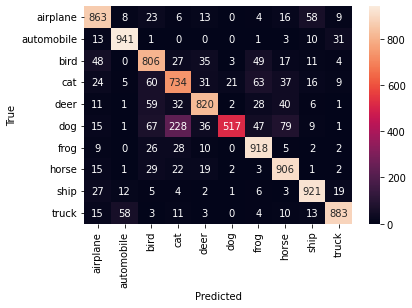

Number of trainable parameters: 11181642


In [24]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(model)}')
# save the model
torch.save(model.state_dict(), 'resnet18_fine-tune.pth')

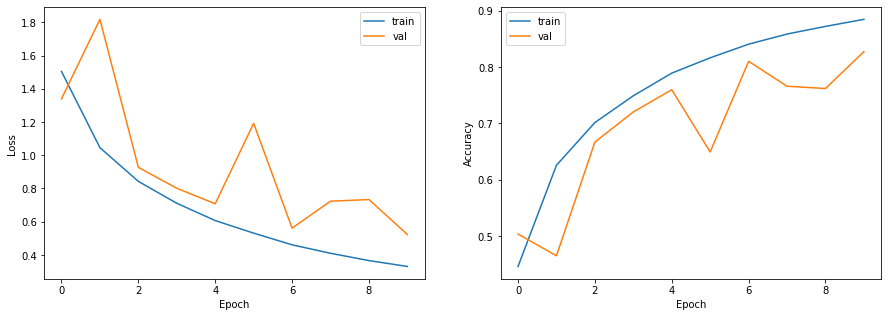

In [25]:
# plot the training and validation loss and accuracy for fine-tuning ResNet18 without knowledge distillation
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparing the results of the knowledge distillation ResNet18 model with the fine-tuned ResNet18 model without distillation, we can see that the accuracy of the model with distillation is slightly higher than the model without distillation. This is because the knowledge distillation model is able to learn from the mistakes of the linear-tuned ResNet50 model. 

In [32]:
# fine-tune all of resnet50 model without knowledge distillation
model = timm.create_model('resnet50', pretrained=False)
model.fc = nn.Linear(2048, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)


Epoch: 1/10 	 Train loss: 1.550 	 Train accuracy: 0.422 	 val loss: 1.473 	 val accuracy: 0.484
Epoch: 2/10 	 Train loss: 1.070 	 Train accuracy: 0.613 	 val loss: 1.030 	 val accuracy: 0.635
Epoch: 3/10 	 Train loss: 0.869 	 Train accuracy: 0.692 	 val loss: 0.976 	 val accuracy: 0.658
Epoch: 4/10 	 Train loss: 0.747 	 Train accuracy: 0.736 	 val loss: 0.775 	 val accuracy: 0.724
Epoch: 5/10 	 Train loss: 0.657 	 Train accuracy: 0.771 	 val loss: 0.702 	 val accuracy: 0.756
Epoch: 6/10 	 Train loss: 0.584 	 Train accuracy: 0.795 	 val loss: 0.747 	 val accuracy: 0.751
Epoch: 7/10 	 Train loss: 0.523 	 Train accuracy: 0.817 	 val loss: 0.662 	 val accuracy: 0.767
Epoch: 8/10 	 Train loss: 0.479 	 Train accuracy: 0.832 	 val loss: 0.559 	 val accuracy: 0.807
Epoch: 9/10 	 Train loss: 0.429 	 Train accuracy: 0.852 	 val loss: 0.532 	 val accuracy: 0.816
Epoch: 10/10 	 Train loss: 0.394 	 Train accuracy: 0.862 	 val loss: 0.616 	 val accuracy: 0.781


              precision    recall  f1-score   support

    airplane     0.8123    0.8050    0.8086      1000
  automobile     0.8045    0.9710    0.8799      1000
        bird     0.6886    0.8070    0.7431      1000
         cat     0.5260    0.8180    0.6403      1000
        deer     0.7907    0.7970    0.7938      1000
         dog     0.7870    0.7130    0.7482      1000
        frog     0.9244    0.7210    0.8101      1000
       horse     0.9787    0.6440    0.7768      1000
        ship     0.9768    0.7590    0.8542      1000
       truck     0.9144    0.8650    0.8890      1000

    accuracy                         0.7900     10000
   macro avg     0.8203    0.7900    0.7944     10000
weighted avg     0.8203    0.7900    0.7944     10000



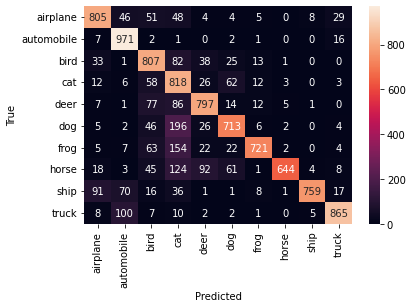

Number of trainable parameters: 23528522


In [33]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(model)}')
# save the model
torch.save(model.state_dict(), 'resnet50_fine-tune.pth')

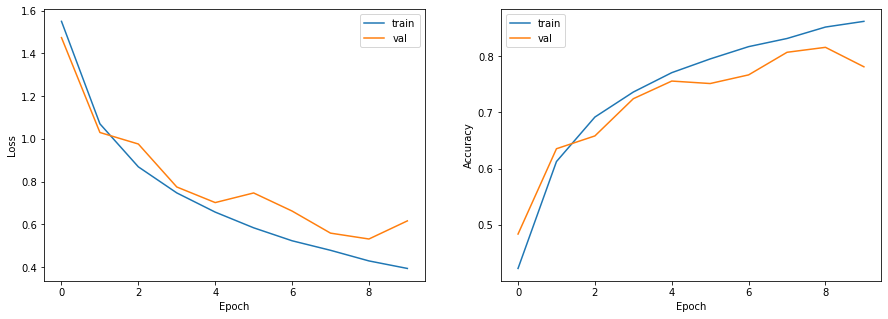

In [34]:
# plot the training and validation loss and accuracy for fine-tuning ResNet50 without knowledge distillation
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Fine-tuning ResNet50 on CIFAR-10 achieves an accuracy of 0.80 on the test set which is smaller than the accuracy of both knowledge distilled and without knowledge distillation ResNet18. This is because the ResNet50 model is too large for the CIFAR-10 dataset. The model is able to overfit the training set and achieve a high accuracy on the training set but is not able to generalize well on the test set. It is obvious that the model is begining to overfit as the validation loss is starting to increase at last few epochs.

In [38]:
# find the best alpha and T for the case where student model is ResNet18 and teacher model is fine-tuned ResNet50
best_acc, best_alpha, best_T = find_best_alpha_T(model, train_loader, val_loader, criterion, optimizer, epochs=2, T_list=[1, 5, 10], alpha_list=[0.2, 0.5, 0.8])

alpha=0.2, T=1
Epoch: 1/2 	 Train loss: 1.459 	 Train accuracy: 0.461 	 val loss: 1.325 	 val accuracy: 0.555
Epoch: 2/2 	 Train loss: 1.003 	 Train accuracy: 0.655 	 val loss: 1.753 	 val accuracy: 0.466
alpha=0.5, T=1
Epoch: 1/2 	 Train loss: 1.466 	 Train accuracy: 0.464 	 val loss: 1.938 	 val accuracy: 0.371
Epoch: 2/2 	 Train loss: 0.996 	 Train accuracy: 0.659 	 val loss: 1.570 	 val accuracy: 0.459
alpha=0.8, T=1
Epoch: 1/2 	 Train loss: 1.474 	 Train accuracy: 0.461 	 val loss: 1.466 	 val accuracy: 0.493
Epoch: 2/2 	 Train loss: 1.009 	 Train accuracy: 0.648 	 val loss: 1.002 	 val accuracy: 0.647
alpha=0.2, T=5
Epoch: 1/2 	 Train loss: 41.435 	 Train accuracy: 0.442 	 val loss: 42.125 	 val accuracy: 0.449
Epoch: 2/2 	 Train loss: 39.402 	 Train accuracy: 0.665 	 val loss: 39.748 	 val accuracy: 0.640
alpha=0.5, T=5
Epoch: 1/2 	 Train loss: 26.582 	 Train accuracy: 0.456 	 val loss: 26.048 	 val accuracy: 0.512
Epoch: 2/2 	 Train loss: 25.058 	 Train accuracy: 0.673 	 val lo

In [39]:
# best_T, best_alpha for the case where student model is ResNet18 and teacher model is fine-tuned ResNet50
print(f"Best T={best_T}, best alpha={best_alpha}")

Best T=10, best alpha=0.5


In [40]:
# train the student model with the best alpha and T for the case where student model is ResNet18 and teacher model is fine-tuned ResNet50
student_model = timm.create_model('resnet18', pretrained=False)
student_model.fc = nn.Linear(512, 10)
student_model.load_state_dict(torch.load('not_pretrained_resnet18.pth'))
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=best_T, alpha=best_alpha)

Epoch: 1/10 	 Train loss: 112.635 	 Train accuracy: 0.449 	 val loss: 114.130 	 val accuracy: 0.391
Epoch: 2/10 	 Train loss: 111.123 	 Train accuracy: 0.674 	 val loss: 111.022 	 val accuracy: 0.683
Epoch: 3/10 	 Train loss: 110.607 	 Train accuracy: 0.764 	 val loss: 110.796 	 val accuracy: 0.735
Epoch: 4/10 	 Train loss: 110.419 	 Train accuracy: 0.807 	 val loss: 110.512 	 val accuracy: 0.781
Epoch: 5/10 	 Train loss: 110.318 	 Train accuracy: 0.829 	 val loss: 110.351 	 val accuracy: 0.816
Epoch: 6/10 	 Train loss: 110.259 	 Train accuracy: 0.846 	 val loss: 110.356 	 val accuracy: 0.819
Epoch: 7/10 	 Train loss: 110.209 	 Train accuracy: 0.856 	 val loss: 110.423 	 val accuracy: 0.817
Epoch: 8/10 	 Train loss: 110.187 	 Train accuracy: 0.868 	 val loss: 110.415 	 val accuracy: 0.790
Epoch: 9/10 	 Train loss: 110.159 	 Train accuracy: 0.876 	 val loss: 110.315 	 val accuracy: 0.834
Epoch: 10/10 	 Train loss: 110.131 	 Train accuracy: 0.882 	 val loss: 110.291 	 val accuracy: 0.848

              precision    recall  f1-score   support

    airplane     0.8433    0.8880    0.8651      1000
  automobile     0.8574    0.9680    0.9093      1000
        bird     0.7535    0.8530    0.8002      1000
         cat     0.6739    0.8040    0.7332      1000
        deer     0.8282    0.8580    0.8428      1000
         dog     0.8945    0.7040    0.7879      1000
        frog     0.8993    0.8660    0.8823      1000
       horse     0.9554    0.8360    0.8917      1000
        ship     0.9733    0.8760    0.9221      1000
       truck     0.9410    0.8770    0.9079      1000

    accuracy                         0.8530     10000
   macro avg     0.8620    0.8530    0.8543     10000
weighted avg     0.8620    0.8530    0.8543     10000



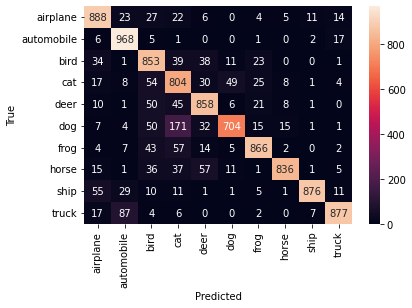

Number of trainable parameters: 11181642


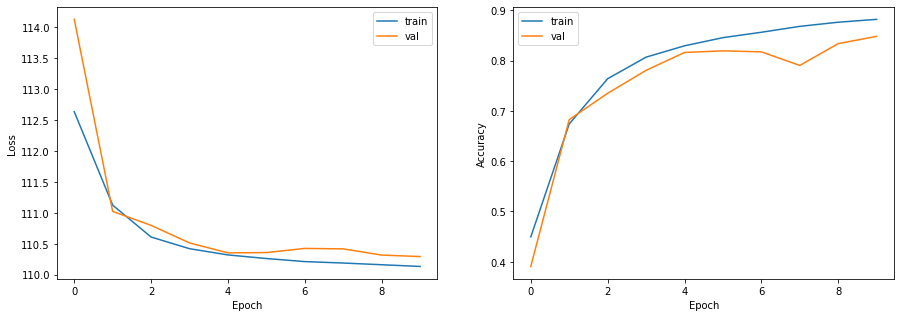

In [41]:
# test the student model on test data
print_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')
torch.save(student_model.state_dict(), 'KD_resnet50_fine-tuned_to_resnet18.pth')
# plot the training and validation loss and accuracy for knowledge distillation with ResNet18 as student model and fine-tuned ResNet50 as teacher model
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### The knowledge distilled model where fine-tuned ResNet50 is the teacher and ResNet18 is the student model achieves an accuracy of 85 on the test set. This is slightly lower than the case where the teacher model is linear-tuned ResNet50 and ResNet18 is the student model. This is because the fine-tuned ResNet50 model is able to overfit the training set and achieve a high accuracy on the training set but is not able to generalize well on the test set.